# Sistem rekomendasi resep makanan
disini kita akan menggunakan content based filtering untuk membuat rekomendasi makanan.

## 1. Importing Libraries

In [12]:
# Library Pengolah Data
import pandas as pd
import numpy as np

# Library System & File
import glob
import os
import pickle  # Untuk menyimpan model
import string  # Untuk membersihkan tanda baca

# Library Visualisasi
import matplotlib.pyplot as plt
import seaborn as sns

# Library Algoritma (Content-Based Filtering)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors

print("Libraries berhasil di-import!")

Libraries berhasil di-import!


##2. Load Dataset & Merging
load dataset dan mengabungkan semua datasetnya menjadi satu

In [13]:
# Mencari file CSV
file_paths = glob.glob('*.csv')
print(f"File CSV ditemukan: {len(file_paths)} file")

df_list = []
for file in file_paths:
    try:
        temp_df = pd.read_csv(file)

        # 1. AMBIL KATEGORI DARI NAMA FILE
        # Misal: "dataset-ayam.csv" -> jadi "ayam"
        nama_file = os.path.basename(file)
        kategori = nama_file.replace('dataset-', '').replace('.csv', '')

        # 2. TAMBAHKAN KOLOM KATEGORI
        temp_df['Category'] = kategori

        df_list.append(temp_df)
        print(f" - Berhasil load: {file} (Kategori: {kategori})")

    except Exception as e:
        print(f" - Gagal membaca {file}: {e}")

# 3. GABUNGKAN SEMUA (MERGE)
if df_list:
    df = pd.concat(df_list, ignore_index=True)

    # 4. SIMPAN DATA GABUNGAN (MENTAH)
    # Ini file bukti penggabungan yang Anda tanyakan
    df.to_csv('data_gabungan_mentah.csv', index=False)

    print(f"\n✅ SUKSES! Data digabung & disimpan ke 'data_gabungan_mentah.csv'")
    print(f"Total Data: {len(df)} baris")
    display(df.head())
else:
    print("Error: Tidak ada file CSV.")

File CSV ditemukan: 8 file
 - Berhasil load: dataset-telur.csv (Kategori: telur)
 - Berhasil load: dataset-sapi.csv (Kategori: sapi)
 - Berhasil load: dataset-tahu.csv (Kategori: tahu)
 - Berhasil load: dataset-ikan.csv (Kategori: ikan)
 - Berhasil load: dataset-udang.csv (Kategori: udang)
 - Berhasil load: dataset-ayam.csv (Kategori: ayam)
 - Berhasil load: dataset-tempe.csv (Kategori: tempe)
 - Berhasil load: dataset-kambing.csv (Kategori: kambing)

✅ SUKSES! Data digabung & disimpan ke 'data_gabungan_mentah.csv'
Total Data: 15641 baris


,Title,Ingredients,Steps,Loves,URL,Category
0,Orak arik telur buncis,1 buah telur--10 buncis--3 bawang merah--2 baw...,"Haluskan bawang merah, bawang putih dan cabai-...",1,/id/resep/4474114-orak-arik-telur-buncis,telur
1,Terik ayam tempe telor,4 sayap ayam--4 buah telor--1/2 papan tempe--B...,Cuci sayap ayam kemudian sisihkan. Rebus telur...,6,/id/resep/4474066-terik-ayam-tempe-telor,telur
2,Telur Kornet,1/2 kaleng kornet--2-3 buah bawang prei--2 bua...,"Campur kornet, telur, bawang prei dan cabe yg ...",7,/id/resep/4473838-telur-kornet,telur
3,Tahu telur surabaya,1 butir telur--1 potong tahu putih goreng sete...,"Uleg kacang, cabai, bawang putih, gula merah, ...",10,/id/resep/4473784-tahu-telur-surabaya,telur
4,Telur ceplok masak kecap,4 butir telur--4 siung bwng merah--2 siung bwn...,Ceplok telur lalu sisihkan--Iris tipis dua bwn...,0,/id/resep/4473512-telur-ceplok-masak-kecap,telur


##3. EDA (Exploratory Data Analysis)


In [14]:
print("=== EDA: CEK KONDISI DATA ===")

# 1. Cek Data Kosong
print("\n[1] Data Kosong (NaN) Awal:")
print(df.isnull().sum())

# 2. Cek Duplikat
jumlah_duplikat = df.duplicated(subset=['Title']).sum()
print(f"\n[2] Jumlah Judul Duplikat: {jumlah_duplikat}")

# 3. Cek Data Sampah
sampah = df[df['Title'].astype(str).str.len() < 2]
print(f"\n[3] Data Sampah (< 2 huruf): {len(sampah)}")

=== EDA: CEK KONDISI DATA ===

[1] Data Kosong (NaN) Awal:
Title           0
Ingredients    48
Steps          46
Loves           0
URL             0
Category        0
dtype: int64

[2] Jumlah Judul Duplikat: 3170

[3] Data Sampah (< 2 huruf): 0


##4. Data Preprocessing (Cleaning)
Membersihkan data dan membuang data yang menjadi kosong setelah dibersihkan.

In [15]:
print("=== PREPROCESSING: MEMBERSIHKAN DATA ===")

# 1. Hapus Duplikat
df = df.drop_duplicates(subset=['Title'], keep='first')

# 2. Isi Data Kosong Awal
df['Title'] = df['Title'].fillna('')
df['Ingredients'] = df['Ingredients'].fillna('')
df['Category'] = df['Category'].fillna('') # Isi kategori kosong

# 3. Fungsi Bersih Teks
def text_cleaning(text):
    if isinstance(text, str):
        # Hapus tanda baca & lowercase
        text = "".join([c for c in text if c not in string.punctuation])
        return text.lower().strip()
    return ''

print("-> Membersihkan teks (Title, Ingredients, Category)...")
df['Title_Clean'] = df['Title'].apply(text_cleaning)
df['Ingredients_Clean'] = df['Ingredients'].apply(text_cleaning)
df['Category_Clean'] = df['Category'].apply(text_cleaning)

# 4. HAPUS Data yang jadi Kosong/NaN setelah cleaning
df['Title_Clean'].replace('', np.nan, inplace=True)
df['Ingredients_Clean'].replace('', np.nan, inplace=True)

print(f"-> Data hilang isinya setelah cleaning: {df['Title_Clean'].isnull().sum()}")

# Buang data tersebut
df = df.dropna(subset=['Title_Clean', 'Ingredients_Clean'])
df = df.reset_index(drop=True)

# 5. SIMPAN DATA BERSIH (SIAP PAKAI)
df.to_csv('data_bersih.csv', index=False)
print(f"\n✅ SUKSES! Data bersih disimpan ke 'data_bersih.csv'")
print(f"Total Data Bersih: {len(df)} baris.")

=== PREPROCESSING: MEMBERSIHKAN DATA ===
-> Membersihkan teks (Title, Ingredients, Category)...


/tmp/ipython-input-3724513558.py:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Title_Clean'].replace('', np.nan, inplace=True)
/tmp/ipython-input-3724513558.py:26: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', t

-> Data hilang isinya setelah cleaning: 0

✅ SUKSES! Data bersih disimpan ke 'data_bersih.csv'
Total Data Bersih: 12468 baris.


##5. Feature Engineering

In [16]:
# --- MODIFIKASI: TITLE BOOSTING ---
def create_combined_features(x):

    title = (x['Title_Clean'] + ' ') * 3


    category = (x['Category_Clean'] + ' ') * 2


    ingredients = (x['Ingredients_Clean'] + ' ') *2

    return title + category + ingredients

# Buat kolom fitur gabungan baru
df['combined_features'] = df.apply(create_combined_features, axis=1)

print("Fitur Gabungan dengan Title Boosting berhasil dibuat!")
print(f"Contoh (Title diulang): {df['combined_features'].iloc[0]}")

Fitur Gabungan dengan Title Boosting berhasil dibuat!
Contoh (Title diulang): orak arik telur buncis orak arik telur buncis orak arik telur buncis telur telur 1 buah telur10 buncis3 bawang merah2 bawang putih6 cabe rawit1 sdm kecap manispenyedap garam gula atau penyedap lainnya 1 buah telur10 buncis3 bawang merah2 bawang putih6 cabe rawit1 sdm kecap manispenyedap garam gula atau penyedap lainnya 


##6. Content Based Filtering Model
Melatih model TF-IDF & Cosine Similarity dengan algoritma knn

In [17]:
print("1. Melatih TF-IDF...")
tfidf = TfidfVectorizer(stop_words=None)
tfidf_matrix = tfidf.fit_transform(df['combined_features'])
print(f"   Ukuran Matrix: {tfidf_matrix.shape}")

print("2. Melatih Model KNN (NearestNeighbors)...")
# Menggunakan metric='cosine' agar cara hitungnya sama dengan cosine similarity
# algorithm='brute' biasanya paling efisien untuk sparse matrix (hasil TF-IDF)
knn_model = NearestNeighbors(metric='cosine', algorithm='brute')
knn_model.fit(tfidf_matrix)

print("✅ Model KNN berhasil dilatih!")

1. Melatih TF-IDF...
   Ukuran Matrix: (12468, 34366)
2. Melatih Model KNN (NearestNeighbors)...
✅ Model KNN berhasil dilatih!


##7. Evaluasi model dan testing

In [21]:
if 'indices' not in globals():
    print("⚠️ Variabel 'indices' belum ada. Membuat ulang...")
    # Mapping Judul Bersih ke Index DataFrame
    indices = pd.Series(df.index, index=df['Title_Clean']).drop_duplicates()

# --- FUNGSI EVALUASI ---
def evaluate_model(title_input, k=10):
    # 1. Cari Index Resep Target
    title_clean = text_cleaning(title_input)

    # Cek apakah judul ada di data
    if title_clean not in indices:
        print(f"❌ Resep '{title_input}' tidak ditemukan dalam database.")
        print("   Tips: Cek penulisan atau coba judul lain dari 'df['Title'].head()'")
        return

    # Ambil index
    idx = indices[title_clean]
    if isinstance(idx, pd.Series): idx = idx.iloc[0]

    # 2. Ambil Kategori Asli (Ini Kunci Jawabannya)
    target_category = df['Category'].iloc[idx]

    # 3. Minta Rekomendasi ke Model KNN
    target_vector = tfidf_matrix[idx]

    # Cari K+1 tetangga
    distances, neighbor_indices = knn_model.kneighbors(target_vector, n_neighbors=k+1)

    neighbor_indices = neighbor_indices.flatten()

    # 4. Hitung Skor Evaluasi
    relevant_count = 0

    print(f"\n📊 --- HASIL EVALUASI UNTUK: {title_input} ---")
    print(f"🏷️ Kategori Asli: {target_category}\n")
    print(f"{'No':<4} {'Judul Rekomendasi':<50} {'Kategori':<15} {'Status'}")
    print("-" * 80)

    # Loop hasil rekomendasi (mulai dari index 1 untuk skip diri sendiri)
    for i, neighbor_idx in enumerate(neighbor_indices[1:], 1):
        rec_title = df['Title'].iloc[neighbor_idx]
        rec_category = df['Category'].iloc[neighbor_idx]

        # Penilaian: Apakah Kategori Rekomendasi SAMA dengan Kategori Target?
        is_relevant = (rec_category == target_category)

        if is_relevant:
            relevant_count += 1
            status = "✅ Relevan"
        else:
            status = "❌ Tidak"

        print(f"{i:<4} {rec_title[:48]:<50} {rec_category:<15} {status}")

    # 5. Hitung Precision & Recall
    precision = relevant_count / k

    total_relevant_in_db = len(df[df['Category'] == target_category]) - 1
    recall = relevant_count / total_relevant_in_db if total_relevant_in_db > 0 else 0

    print("-" * 80)
    print(f"📊 Skor Evaluasi untuk '{title_input}':")
    print(f"📈 Precision@{k}: {precision * 100:.2f} (Dari {k} saran, {relevant_count} sesuai kategori)")
    print(f"📈 Recall@{k}   : {recall * 100:.2f} (Berhasil menemukan {relevant_count} dari total {total_relevant_in_db} resep '{target_category}' di DB)")

# --- JALANKAN TEST ---
evaluate_model("Martabak tahu pedas kulit lumpia")


📊 --- HASIL EVALUASI UNTUK: Martabak tahu pedas kulit lumpia ---
🏷️ Kategori Asli: tahu

No   Judul Rekomendasi                                  Kategori        Status
--------------------------------------------------------------------------------
1    Martabak Tahu Kulit Lumpia                         tahu            ✅ Relevan
2    Martabak Tahu Telur                                tahu            ✅ Relevan
3    Martabak Tahu Daging                               tahu            ✅ Relevan
4    Lumpia isi tahu                                    tahu            ✅ Relevan
5    Martabak kriuk isi tahu wortel                     tahu            ✅ Relevan
6    Martabak tahu                                      tahu            ✅ Relevan
7    Martabak tahu cornet                               tahu            ✅ Relevan
8    Martabak tahu tongkol                              tahu            ✅ Relevan
9    Martabak Tahu Kulit Pangsit                        tahu            ✅ Relevan
10   Martaba

##8. Data Visualization (Similarity Scores)
Visualisasi skor kemiripan.

📊 Menyiapkan grafik untuk: Terik ayam tempe telor...


/tmp/ipython-input-2685979015.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x=plot_scores, y=plot_titles, palette='viridis')


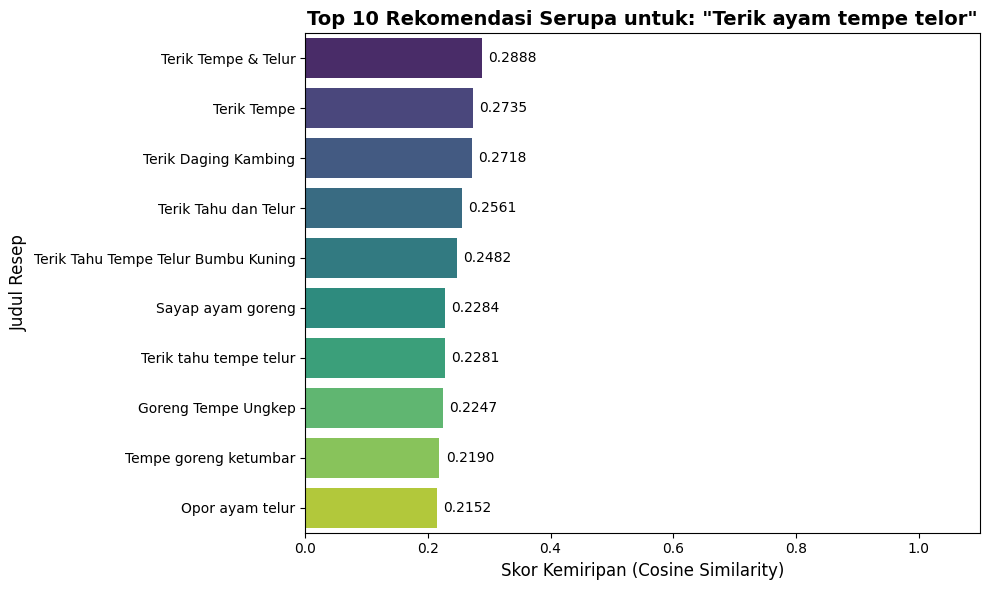

In [22]:
def visualize_similarity_knn(title_input, k=10):
    # 1. Cari Index Resep Target
    title_clean = text_cleaning(title_input)
    if title_clean not in indices:
        print(f"❌ Resep '{title_input}' tidak ditemukan.")
        return

    idx = indices[title_clean]
    if isinstance(idx, pd.Series): idx = idx.iloc[0]

    # 2. Hitung Jarak dengan KNN
    # Ambil vektor target
    target_vector = tfidf_matrix[idx]

    # Cari tetangga terdekat beserta jaraknya (distances)
    # k+1 karena hasil pertama adalah diri sendiri
    distances, neighbor_indices = knn_model.kneighbors(target_vector, n_neighbors=k+1)

    # Ratakan array hasil
    neighbor_indices = neighbor_indices.flatten()
    distances = distances.flatten()

    # 3. Konversi Jarak ke Skor Kemiripan (Similarity Score)
    # Karena KNN pake 'cosine distance', maka: Similarity = 1 - Distance
    similarity_scores = 1 - distances

    # 4. Siapkan Data untuk Plotting (Skip index 0 / diri sendiri)
    plot_indices = neighbor_indices[1:]
    plot_scores = similarity_scores[1:]
    plot_titles = df['Title'].iloc[plot_indices].tolist()

    # 5. Buat Grafik
    plt.figure(figsize=(10, 6))

    # Gunakan palet warna yang menarik
    barplot = sns.barplot(x=plot_scores, y=plot_titles, palette='viridis')

    plt.title(f'Top {k} Rekomendasi Serupa untuk: "{title_input}"', fontsize=14, fontweight='bold')
    plt.xlabel('Skor Kemiripan (Cosine Similarity)', fontsize=12)
    plt.ylabel('Judul Resep', fontsize=12)
    plt.xlim(0, 1.1)  # Batas sumbu X dari 0 sampai 1.1 agar teks skor muat

    # Tambahkan angka skor di ujung batang grafik
    for i, v in enumerate(plot_scores):
        barplot.text(v + 0.01, i, f"{v:.4f}", va='center', fontsize=10)

    plt.tight_layout()
    plt.show()

# --- JALANKAN VISUALISASI ---
if not df.empty:
    # Ambil contoh judul (misal baris ke-1)
    judul_tes = df['Title'].iloc[1]
    print(f"📊 Menyiapkan grafik untuk: {judul_tes}...")
    visualize_similarity_knn(judul_tes)

##9. Saving Model

In [23]:
if not os.path.exists('models'):
    os.makedirs('models')

print("Sedang menyimpan model...")

# 1. Simpan Data Resep (Tetap)
pickle.dump(df, open('models/recipes.pkl', 'wb'))
print("✅ recipes.pkl tersimpan.")

# 2. Simpan TF-IDF Vectorizer (Tetap - Penting untuk fitur 'Rekomendasi Untuk Kamu')
pickle.dump(tfidf, open('models/tfidf_vectorizer.pkl', 'wb'))
print("✅ tfidf_vectorizer.pkl tersimpan.")

# 3. Simpan TF-IDF Matrix (Tetap - Penting untuk fitur 'Rekomendasi Untuk Kamu')
pickle.dump(tfidf_matrix, open('models/tfidf_matrix.pkl', 'wb'))
print("✅ tfidf_matrix.pkl tersimpan.")

# 4. SIMPAN MODEL KNN (BARU)
pickle.dump(knn_model, open('models/knn_model.pkl', 'wb'))
print("✅ knn_model.pkl tersimpan.")

print("\nSUKSES! Download 4 file ini dan upload ke folder 'models' di project Flask kamu.")

Sedang menyimpan model...
✅ recipes.pkl tersimpan.
✅ tfidf_vectorizer.pkl tersimpan.
✅ tfidf_matrix.pkl tersimpan.
✅ knn_model.pkl tersimpan.

SUKSES! Download 4 file ini dan upload ke folder 'models' di project Flask kamu.
